In [1]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import h5py
import os
import glob                                                                                                                                                        
import wget
import torch
import umap
import sys
dataloader_path = '/arc/home/ashley/SSL/git/dark3d/src/models/training_framework/'
sys.path.insert(0, dataloader_path)
import dataloaders
canfar_data_path = '/arc/projects/unions/ssl/data/processed/unions-cutouts/ugriz_lsb/10k_per_h5/'

In [2]:
from models_mae import mae_vit_large_patch16
mae_model = mae_vit_large_patch16()

2024-03-01 18:51:06,898 - jax._src.path - DEBUG - etils.epath found. Using etils.epath for file I/O.
2024-03-01 18:51:08,018 - git.cmd - DEBUG - Popen(['git', 'version'], cwd=/arc/home/ashley/SSL/git/mae_jan21/AstroMASK, stdin=None, shell=False, universal_newlines=False)
2024-03-01 18:51:08,030 - git.cmd - DEBUG - Popen(['git', 'version'], cwd=/arc/home/ashley/SSL/git/mae_jan21/AstroMASK, stdin=None, shell=False, universal_newlines=False)
2024-03-01 18:51:08,048 - wandb.docker.auth - DEBUG - Trying paths: ['/arc/home/ashley/.docker/config.json', '/arc/home/ashley/.dockercfg']
2024-03-01 18:51:08,050 - wandb.docker.auth - DEBUG - No config file found
2024-03-01 18:51:08,309 - sentry_sdk.errors - DEBUG - [Tracing] Create new propagation context: {'trace_id': '3b6fdd04180e40cca28ae7793124b765', 'span_id': '92820d83a46cb015', 'parent_span_id': None, 'dynamic_sampling_context': None}


In [3]:
checkpoint_path = "/arc/projects/unions/ssl/data/processed/unions-cutouts/ugriz_lsb/10k_per_h5/mae/output_dir/to_save/checkpoint-60.pth"
checkpoint = torch.load(checkpoint_path)
mae_model.load_state_dict(checkpoint['model'])

device = torch.device('cuda')
mae_model.to(device)
mae_model.eval()

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 1024, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (d

In [4]:
# read in redshift files
matches = pd.read_csv('spencer_redshifts.csv').sample(frac = 1) # random shuffle is applied to table
matches.head()

,Unnamed: 0,ra_2,dec_2,zspec,file_num,index
24214,37885,32.526857,32.870988,0.086739,21,3324
71436,85305,146.101660,38.498625,0.546000,352,4450
147192,161061,3.029563,32.461199,0.082727,482,2597
5353,10989,13.004865,32.744745,0.152078,325,3260
36756,50599,122.360971,32.094652,0.794000,313,7849


2024-03-01 18:51:24,269 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-01 18:51:24,272 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-01 18:51:24,276 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-03-01 18:51:24,278 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-03-01 18:51:24,279 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', 

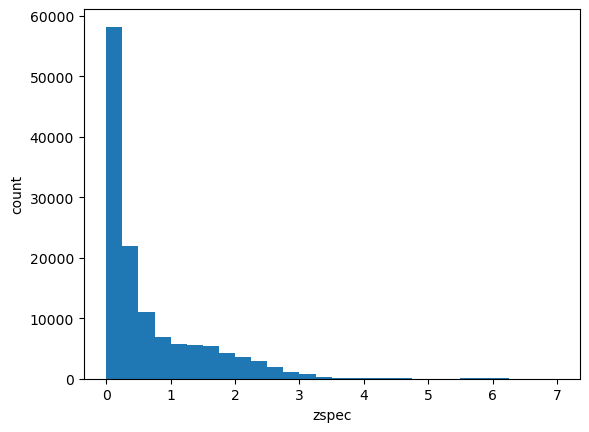

[5.8179e+04 2.1900e+04 1.1044e+04 6.9430e+03 5.6630e+03 5.6510e+03
 5.3680e+03 4.1930e+03 3.5940e+03 2.9470e+03 1.8630e+03 1.1160e+03
 7.1300e+02 3.1400e+02 1.6200e+02 1.0000e+02 9.6000e+01 5.1000e+01
 5.1000e+01 3.5000e+01 2.1000e+01 2.8000e+01 4.8000e+01 4.2000e+01
 4.0000e+01 5.0000e+00 4.0000e+00 2.0000e+00]


In [5]:
# look at redshift distribution
counts, bins, patches = plt.hist(matches['zspec'], bins=np.arange(0,max(matches['zspec']),0.25))
plt.ylabel('count')
plt.xlabel('zspec')
plt.show()
print(counts)

In [6]:
# filter out the extremely high and extremely low redshift entries
matches = matches[matches['zspec']>0.1]
matches = matches[matches['zspec']<6]

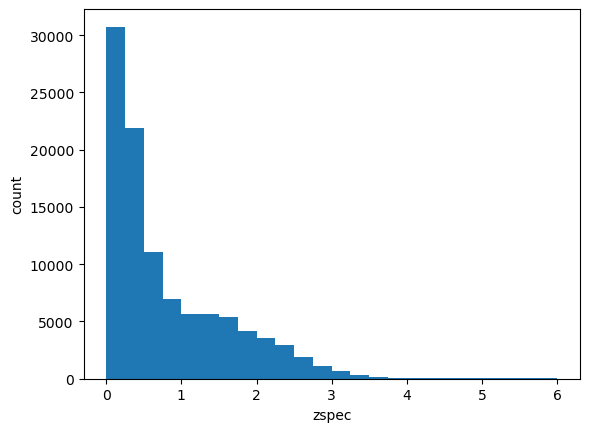

[3.0742e+04 2.1900e+04 1.1044e+04 6.9430e+03 5.6630e+03 5.6510e+03
 5.3680e+03 4.1930e+03 3.5940e+03 2.9470e+03 1.8630e+03 1.1160e+03
 7.1300e+02 3.1400e+02 1.6200e+02 1.0000e+02 9.6000e+01 5.1000e+01
 5.1000e+01 3.5000e+01 2.1000e+01 2.8000e+01 4.8000e+01 4.2000e+01]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.  ]


In [7]:
# look at distribution again with specified bin size
bin_size = 0.25
counts, bins, patches = plt.hist(matches['zspec'], bins=np.arange(0,6+bin_size, bin_size))
plt.ylabel('count')
plt.xlabel('zspec')
plt.show()
print(counts)
print(bins)

In [12]:
### now self-sample for flat distribution ###
# smallest bar seems to have a count of 21 so to insure a flat
# distribution we will just sample each bar up to 20 counts

match_zspec = np.array(matches['zspec'])
'''
dict = {}
for b in bins:
    dict[b] = []
for i in range(len(match_zspec)):
    s = np.round(match_zspec[i] // bin_size) * bin_size # this part not correct? fixed now!

    # making this much larger to see if it helps
    if len(dict[s]) < 200:# 20, 50, 200: # you can make this number larger (like 50) without a significant change in the distribution
        dict[s].append(i)

train_set = list(itertools.chain.from_iterable(dict.values()))
'''

train_set = list(range(1024*2))

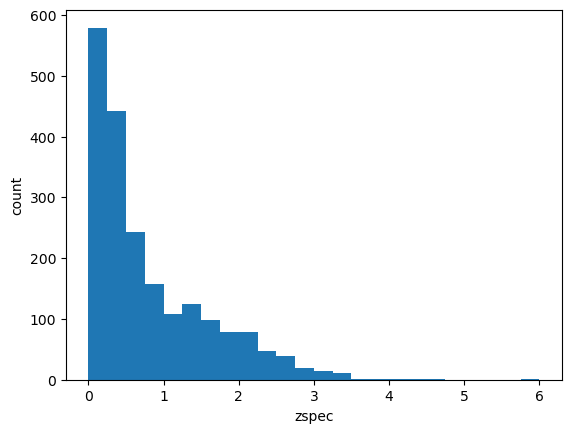

total entries in train_lst: 2048


In [13]:
# visualize the distribution of this train list to make sure it is flat
counts, bins, patches = plt.hist(match_zspec[train_set], bins=np.arange(0,6+bin_size, bin_size)) 
plt.ylabel('count')
plt.xlabel('zspec')
plt.show()
print('total entries in train_lst:', len(train_set))

In [14]:
# loop over table and save representations and redshifts for all entries in this train_set
cutouts = []
redshifts = []
index_count = 0
for i, row in matches.iterrows():
    if index_count in train_set:
        redshifts.append(row['zspec'])
        file_num = int(row['file_num']) 
        filename = f'cutout.stacks.ugriz.lsb.200x200.{file_num}.10000.h5'
        f = h5py.File(canfar_data_path + filename,'r')
        index = int(row['index'])
        image = f['images'][index]
        cutouts.append(dataloaders.utils.crop_center(image, cropx=64, cropy=64))

    index_count +=1 

cutouts = np.array(cutouts)
cutouts = torch.from_numpy(cutouts)
cutouts = cutouts.float().to(device, non_blocking=True)
with torch.no_grad():
    with torch.cuda.amp.autocast():
        latent_representation, _, _ = mae_model.forward_encoder(cutouts, mask_ratio=0.0)
        
del cutouts
latent_representation = latent_representation.cpu().numpy()
batch_size, extra, dim = latent_representation.shape
#flattened_representation = latent_representation.reshape(batch_size, extra*dim)
#del latent_representation

In [15]:
print(latent_representation.shape)

(2048, 65, 1024)


In [16]:
# normalize flattened representations - have tried with and without this
##norms = np.linalg.norm(flattened_representation, keepdims=True, axis=0) 
##normalized_reps = flattened_representation / norms
##del flattened_representation
##print(normalized_reps.shape) 
##print(norms.shape)

def central_indices(tensor_2d, n):
    """
    Returns the indices of the central 'n' pixels of a 2D tensor.
    
    Parameters:
    tensor_2d (Tensor): A 2D tensor from which to find central indices.
    n (int): Number of central pixels to find.

    Returns:
    Tensor: Indices of the central 'n' pixels.
    """
    # Ensure 'n' is a square number to form a square patch of pixels
    side_length = int(n ** 0.5)
    if side_length ** 2 != n:
        raise ValueError("n must be a perfect square to form a square patch of pixels.")
    
    # Calculate the center of the tensor
    center_y, center_x = tensor_2d.shape[0] // 2, tensor_2d.shape[1] // 2
    
    # Calculate start and end indices for the slice
    start_y = center_y - side_length // 2
    end_y = start_y + side_length
    start_x = center_x - side_length // 2
    end_x = start_x + side_length
    
    # Create meshgrid of indices and then flatten
    yy, xx = torch.meshgrid(torch.arange(start_y, end_y), torch.arange(start_x, end_x), indexing="ij")
    indices = torch.stack((yy.flatten(), xx.flatten()), dim=1)
    
    return indices

def select_centre(latent, n_patches):
    '''
    Grab the central n_patches from a set of latent features.
    
    Parameters:
    latent (Tensor): A 3D tensor from which to select the centre from (b, number of original patches, n_features)
    n_patches (int): Number of central patches to find.

    Returns:
    Tensor: A 3D tensor of the central latent features (b, n_patches, n_features)
    '''
    
    total_n_patches = latent.shape[1]
    n_patches_per_side = int(total_n_patches**0.5)
    patch_indices = torch.arange(total_n_patches).reshape((n_patches_per_side, n_patches_per_side))
    
    indices = central_indices(patch_indices, n=n_patches)
    patch_indices = patch_indices[indices[:,0],indices[:,1]]
    return latent[:,patch_indices]

## ADDED
#  [:, 1:, :] removes cls token
X = select_centre(latent_representation[:, 1:, :], n_patches=4) 
X = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
X = scaler.fit_transform(X) 

Learned Parameters:
Weights: [-0.0098999   0.01042908 -0.         ...  0.02330694 -0.
 -0.        ]
Intercept: 0.81344306
2024-03-01 19:10:41,983 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-03-01 19:10:41,985 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-03-01 19:10:41,987 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-03-01 19:10:41,988 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/

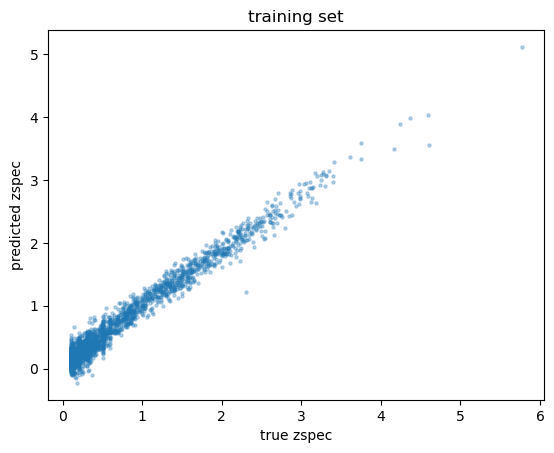

In [19]:
##X = normalized_reps
X = np.nan_to_num(X, nan=0)
y = np.array(redshifts)

linear_model = ElasticNet(alpha=0.001, l1_ratio=0.9, max_iter=10000, random_state=42) ##LinearRegression()
linear_model.fit(X, y)

print("Learned Parameters:")
print("Weights:", linear_model.coef_)
print("Intercept:", linear_model.intercept_)

y_pred = linear_model.predict(X)
plt.scatter(y, y_pred, alpha=0.3, s=5)
plt.ylabel('predicted zspec')
plt.xlabel('true zspec')
plt.title('training set')
plt.show()

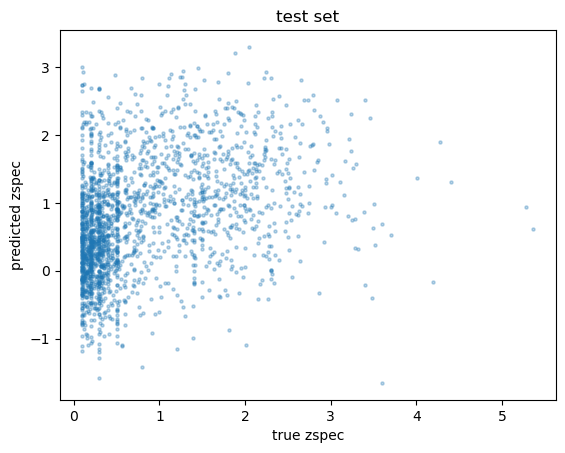

In [21]:
iterations = 1
for k in range(iterations):
    # get a 2k sample to use as test set (could do this sample better)
    cutouts = []
    redshifts = []
    index_count = 0
    for i, row in matches.iterrows():
        if not index_count in train_set:
            redshifts.append(row['zspec'])
            file_num = int(row['file_num']) 
            filename = f'cutout.stacks.ugriz.lsb.200x200.{file_num}.10000.h5'
            f = h5py.File(canfar_data_path + filename,'r')
            index = int(row['index'])
            image = f['images'][index]
            cutouts.append(dataloaders.utils.crop_center(image, cropx=64, cropy=64))
    
        index_count +=1 
        if len(redshifts) >= 2048:
            break
    
    cutouts = np.array(cutouts)
    cutouts = torch.from_numpy(cutouts)
    cutouts = cutouts.float().to(device, non_blocking=True)
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            latent_representation, _, _ = mae_model.forward_encoder(cutouts, mask_ratio=0.0)
    
    del cutouts
    
    latent_representation = latent_representation.cpu().numpy()
    batch_size, extra, dim = latent_representation.shape
    ##flattened_representation = latent_representation.reshape(batch_size, extra*dim)
    ##del latent_representation
    
    ##normalized_reps = flattened_representation / norms
    ##del flattened_representation

    normalized_reps = select_centre(latent_representation[:, 1:, :], n_patches=4) 
    normalized_reps = normalized_reps.reshape(normalized_reps.shape[0], -1)
    normalized_reps = scaler.transform(normalized_reps)

    redshifts = np.array(redshifts)

    y_pred_test = linear_model.predict(np.nan_to_num(normalized_reps, nan=0))
    plt.scatter(redshifts, y_pred_test, alpha=0.3, s=5)
    plt.ylabel('predicted zspec')
    plt.xlabel('true zspec')
    plt.title('test set')

plt.show()

I think it must be overtraining? I also think that there must be a better form for me to input the representations into the linear regression model?

I've tried varying the amount of samples in each bin and the range to predict over but it still doesn't seem to work :(